In [1]:
import numpy as np
import pandas as pd
import torch
from EOS_Solver import EoSNetwork, chi2_loss
import matplotlib.pyplot as plt
from TOV_Solver import WaveNetTOV
from preprocessing import eos_load_and_preprocess

Using device: cuda


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Input Data

In [3]:
observed_mr = pd.read_csv("data/sample_mr.csv")
observed_eos = pd.read_csv("data/sample_eos.csv")

MR_relations = np.load("data/Y_scaled.npy")

M_MAX = observed_mr["M"].max()
R_MAX = 16.0
R_MIN = observed_mr["R"].min()


rho_scaled, P_scaled, M_scaled, R_scaled, dM, dR = eos_load_and_preprocess()


# final observed points (from data only)
M_targets =  M_scaled * M_MAX
R_targets = R_scaled * (R_MAX - R_MIN) + R_MIN

M_obs = MR_relations[0][:,0] * M_MAX
R_obs = MR_relations[0][:,1] * (R_MAX - R_MIN) + R_MIN

M_11 (scaled): [0.43519098 0.48240095 0.5295348  0.5758283  0.62148213 0.6642838
 0.7031093  0.73559916 0.7596531  0.7729905  0.776978  ]
R_11 (scaled): [0.3871338  0.3836161  0.37998658 0.37011364 0.35769168 0.33764187
 0.31069028 0.2763996  0.23574668 0.19042653 0.14331959]
rho_scaled (full): [0.         0.0015873  0.0031746  0.0047619  0.00634921 0.00793651
 0.00952381 0.01111111 0.01269841 0.01428572 0.01587302 0.01746032
 0.01904762 0.02063492 0.02222222 0.02380952 0.02539683 0.02698413
 0.02857143 0.03015873 0.03174603 0.03333334 0.03492064 0.03650794
 0.03809524 0.03968254 0.04126984 0.04285714 0.04444445 0.04603174
 0.04761905 0.04920635 0.05079365 0.05238095 0.05396825 0.05555556
 0.05714286 0.05873016 0.06031746 0.06190476 0.06349207 0.06507937
 0.06666667 0.06825397 0.06984127 0.07142857 0.07301588 0.07460319
 0.07619047 0.07777777 0.07936508 0.08095238 0.08253969 0.08412698
 0.08571429 0.08730159 0.08888889 0.09047619 0.09206349 0.0936508
 0.0952381  0.0968254  0.0984127  0

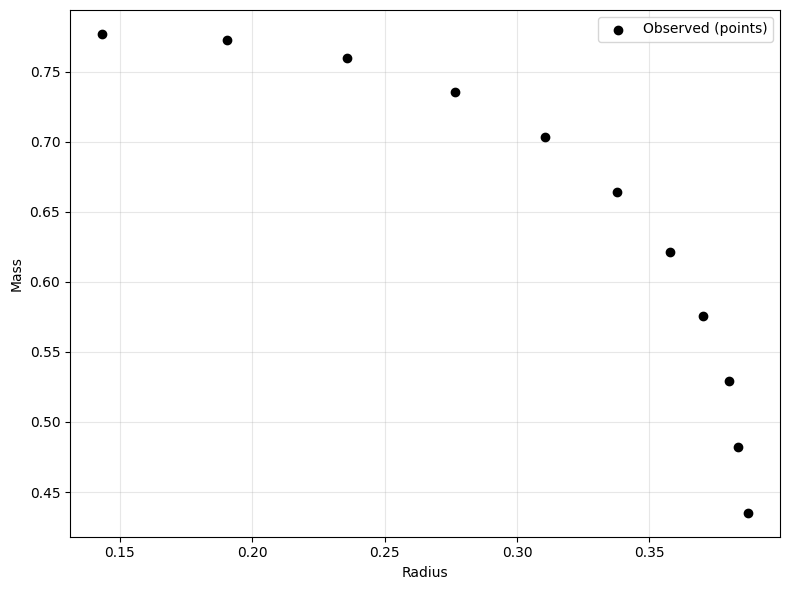

In [4]:
# --- Plot ---
plt.figure(figsize=(8, 6))
plt.scatter(R_scaled, M_scaled, color="black", label="Observed (points)", zorder=3)
plt.xlabel("Radius")
plt.ylabel("Mass")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

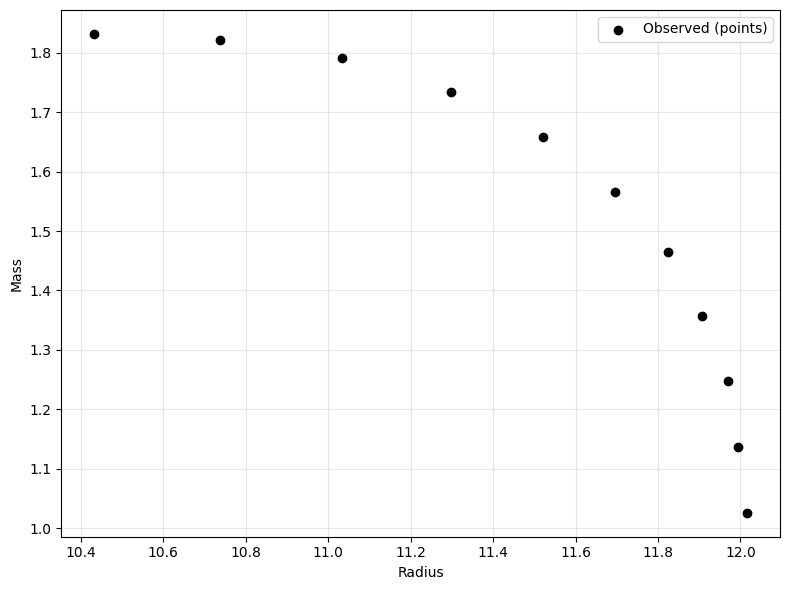

In [5]:
# --- Plot ---
plt.figure(figsize=(8, 6))
plt.scatter(R_targets, M_targets, color="black", label="Observed (points)", zorder=3)
plt.xlabel("Radius")
plt.ylabel("Mass")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Results

In [6]:
# Load TOV-Solver Network
tov = WaveNetTOV().to(device)
tov.load_state_dict(torch.load("models/tov_solver.pt", map_location=device))
tov.eval()

# Load EoS Network
eos = EoSNetwork().to(device)
eos.load_state_dict(torch.load("models/eos_solver.pt", map_location=device))
eos.eval()


EoSNetwork(
  (act): ELU(alpha=1.0)
  (conv1): Conv1d(1, 128, kernel_size=(1,), stride=(1,), padding=same)
  (conv2): Conv1d(128, 128, kernel_size=(1,), stride=(1,), padding=same)
  (conv3): Conv1d(128, 1, kernel_size=(1,), stride=(1,), padding=same)
)

In [7]:
rho_t = torch.tensor(rho_scaled, dtype=torch.float32, device=device).reshape(1, -1, 1)
p_pred = eos(rho_t)

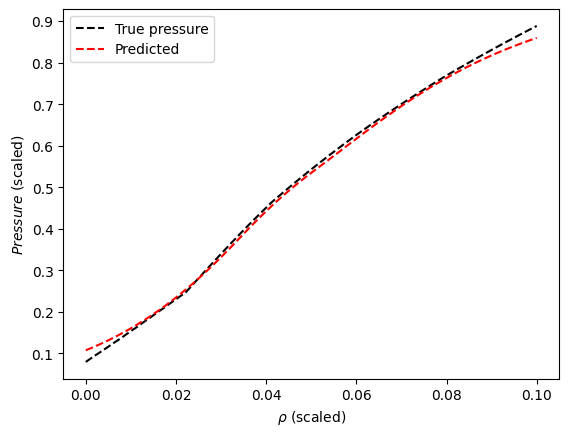

In [8]:
x = rho_scaled.squeeze()

plt.plot(rho_scaled, P_scaled.squeeze(), "--", color="black", label="True pressure", zorder=3)
plt.plot(rho_scaled,  p_pred.detach().cpu().numpy().squeeze(),  "--", color="red", label="Predicted", zorder=3)

plt.xlabel(r"$\rho$ (scaled)")
plt.ylabel(r"$Pressure$ (scaled)")
plt.legend()
plt.show()

In [9]:
p_pred

tensor([[[0.1070],
         [0.1141],
         [0.1217],
         [0.1298],
         [0.1383],
         [0.1474],
         [0.1570],
         [0.1671],
         [0.1777],
         [0.1889],
         [0.2007],
         [0.2131],
         [0.2260],
         [0.2396],
         [0.2537],
         [0.2685],
         [0.2838],
         [0.2997],
         [0.3161],
         [0.3331],
         [0.3505],
         [0.3685],
         [0.3867],
         [0.4046],
         [0.4220],
         [0.4388],
         [0.4551],
         [0.4708],
         [0.4860],
         [0.5006],
         [0.5146],
         [0.5280],
         [0.5409],
         [0.5538],
         [0.5668],
         [0.5800],
         [0.5931],
         [0.6063],
         [0.6193],
         [0.6323],
         [0.6451],
         [0.6577],
         [0.6701],
         [0.6823],
         [0.6941],
         [0.7058],
         [0.7171],
         [0.7281],
         [0.7387],
         [0.7491],
         [0.7591],
         [0.7688],
         [0.

In [10]:
P_scaled

array([0.07890793, 0.09106427, 0.1022849 , 0.11390591, 0.12588078,
       0.13719235, 0.14974809, 0.16130811, 0.17389017, 0.18577617,
       0.19825456, 0.21029241, 0.22274607, 0.23478203, 0.2472499 ,
       0.2662908 , 0.28521904, 0.30403042, 0.32271293, 0.3412335 ,
       0.35956302, 0.37766734, 0.39551908, 0.41308567, 0.43034464,
       0.44727844, 0.46405417, 0.47887838, 0.49344513, 0.50774705,
       0.52196133, 0.53591967, 0.5496461 , 0.563244  , 0.57658774,
       0.5897949 , 0.6028043 , 0.6156044 , 0.6282816 , 0.640472  ,
       0.65249413, 0.6643608 , 0.67608064, 0.6876589 , 0.69909656,
       0.7103943 , 0.7215507 , 0.7325658 , 0.7434763 , 0.7542379 ,
       0.7648875 , 0.7750093 , 0.78503466, 0.79493964, 0.80473423,
       0.8144328 , 0.8240244 , 0.8335122 , 0.84289986, 0.8521947 ,
       0.8613892 , 0.8704868 , 0.8794954 , 0.88841164], dtype=float32)

In [11]:
rho_t = torch.tensor(rho_scaled, dtype=torch.float32, device=device).reshape(1, -1, 1)
p_pred = eos(rho_t)

mr_pred = tov(p_pred)
mr_pred = mr_pred.detach().cpu().numpy().squeeze()

m_pred = mr_pred[:,0] * M_MAX
r_pred = mr_pred[:,1] * (R_MAX - R_MIN) + R_MIN

In [12]:
mr = tov(torch.tensor(P_scaled, dtype=torch.float32, device=device).reshape(1, -1, 1)).detach().cpu().numpy().squeeze()
mass = mr[:,0] * M_MAX
radius = mr[:,1] * (R_MAX - R_MIN) + R_MIN

In [13]:
mr.shape

(64, 2)

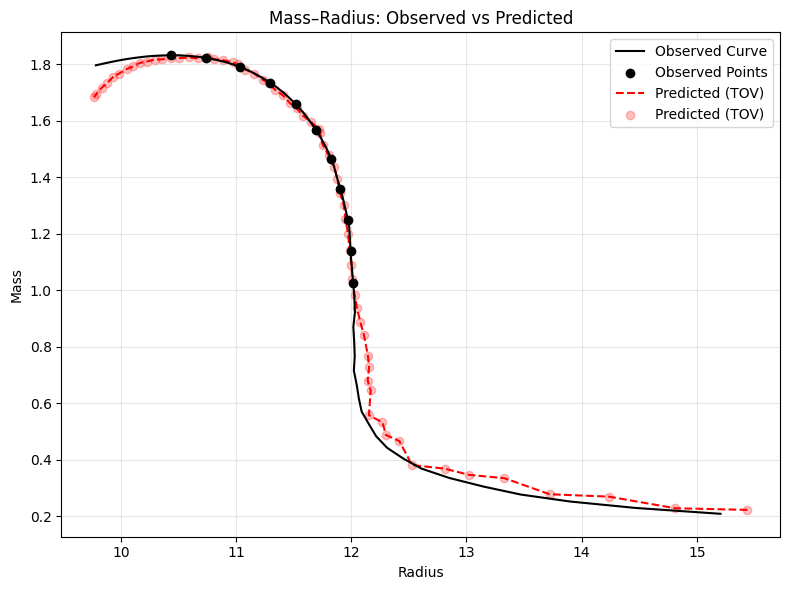

In [14]:
# --- Plot ---
plt.figure(figsize=(8, 6))
plt.plot(R_obs, 
        M_obs, color="black", label="Observed Curve", zorder=3)
plt.scatter(R_targets, M_targets, color="black", label="Observed Points", zorder=3)
plt.plot(r_pred, m_pred, "--", color="red", label="Predicted (TOV)", zorder=1)
plt.scatter(r_pred, m_pred, alpha=0.25, color="red", label="Predicted (TOV)", zorder=1)
plt.xlabel("Radius")
plt.ylabel("Mass")
plt.title("Mass–Radius: Observed vs Predicted")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

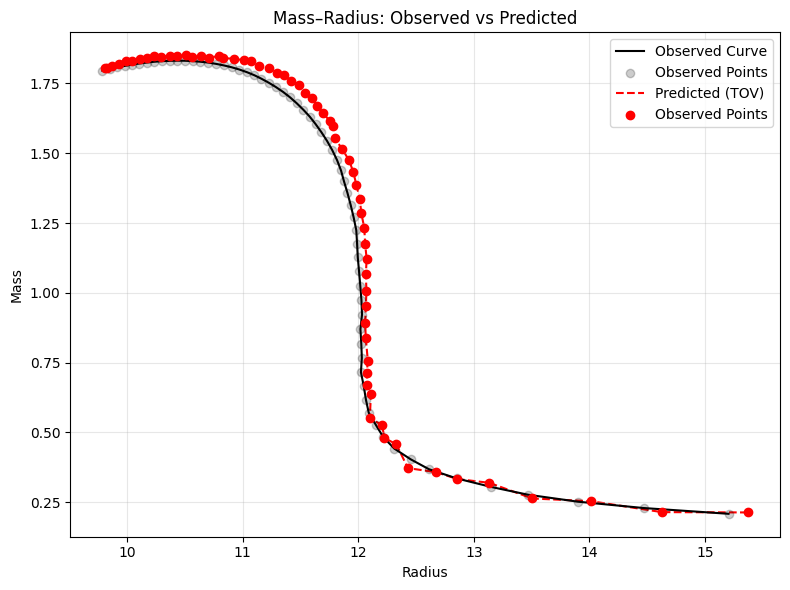

In [15]:
# --- Plot ---
plt.figure(figsize=(8, 6))
plt.plot(R_obs, M_obs, color="black", label="Observed Curve", zorder=3)
plt.scatter(R_obs, M_obs, alpha=0.2, color="black", label="Observed Points", zorder=3)
plt.plot(radius, mass, "--", color="red", label="Predicted (TOV)", zorder=1)
plt.scatter(radius, mass, color="red", label="Observed Points", zorder=3)
plt.xlabel("Radius")
plt.ylabel("Mass")
plt.title("Mass–Radius: Observed vs Predicted")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [16]:
mr.shape

(64, 2)

In [17]:
M_obs = torch.from_numpy(M_scaled).float()
R_obs = torch.from_numpy(R_scaled).float()
dM_t  = torch.from_numpy(dM).float()
dR_t  = torch.from_numpy(dR).float()

criterion = chi2_loss(M_obs, R_obs, dM_t, dR_t)
print(criterion(torch.from_numpy(mr).float().unsqueeze(0)).item())


0.0025794608518481255


Realistic Scenario

In [18]:
res = np.load("data/realistic/realistic_predictions.npz")

M_MAX = res["M_MAX"]
R_MIN = res["R_MIN"]
R_MAX = res["R_MAX"]

rho_scaled = res["rho_scaled"]                         # (Np,)
p_pred_samples = res["p_pred_samples"]                 # (Nsamples, Np)
M_pred_samples = res["M_pred_samples"]                 # (Nsamples, Nseq)
R_pred_samples = res["R_pred_samples"]                 # (Nsamples, Nseq)

M_samples = res["M_samples"] * M_MAX
R_samples = res["R_samples"] * (R_MAX - R_MIN) + R_MIN
dM_samples = res["dM_samples"]
dR_samples = res["dR_samples"]

print(p_pred_samples.shape)
print(f"Training convergence rate: {42/200*100:.1f}%.")


(42, 32)
Training convergence rate: 21.0%.


In [19]:
true_eos = observed_eos.query("ID == 19248").query("model == 'RMFNL'")
p_mean = p_pred_samples.mean(axis=0)

In [20]:
# plt.plot(rho_scaled, p_mean, "--", color="red", label="Mean EoS", zorder=4)
# plt.plot(true_eos["rho"].values, 
#         true_eos["p"].values, color="black", label="Observed EoS Curve", zorder=1)
# plt.xlabel("Density ( sat)")
# plt.ylabel("Pressure (MeV/fm³)")
# plt.title("Predicted Equation of State")
# plt.legend()
# plt.grid(True)
# plt.show()

In [21]:
# (Nsamples, Nseq)
mean_M = M_pred_samples.mean(axis=0) 

mean_R = R_pred_samples.mean(axis=0)

NameError: name 'radius_obs' is not defined

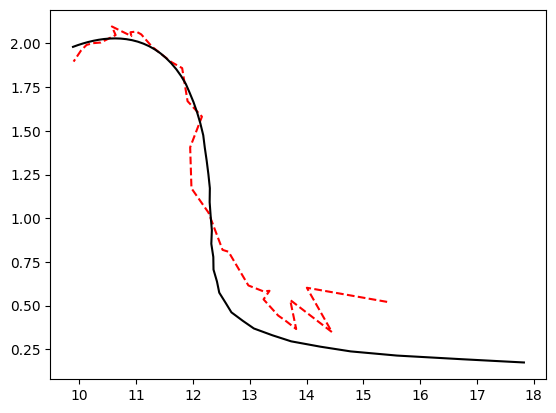

In [22]:
plt.plot(mean_R, mean_M, "--", color="red", label="Mean MR", zorder=1)
plt.plot(observed_mr.query("ID == 19248").query("model == 'RMFNL'")["R"].values, 
        observed_mr.query("ID == 19248").query("model == 'RMFNL'")["M"].values, color="black", label="Observed Curve", zorder=4)
plt.scatter(radius_obs, mass_obs, color="black", label="Observed Points", zorder=4)
plt.scatter(R_samples.flatten(),M_samples.flatten(), color='lightblue', alpha=0.4, label="Samples", zorder=0)
plt.xlabel("Radius (km)")
plt.ylabel("Mass (solar masses)")
plt.title("Predicted Mass–Radius Relation")
plt.legend()
plt.grid(True)
plt.show()

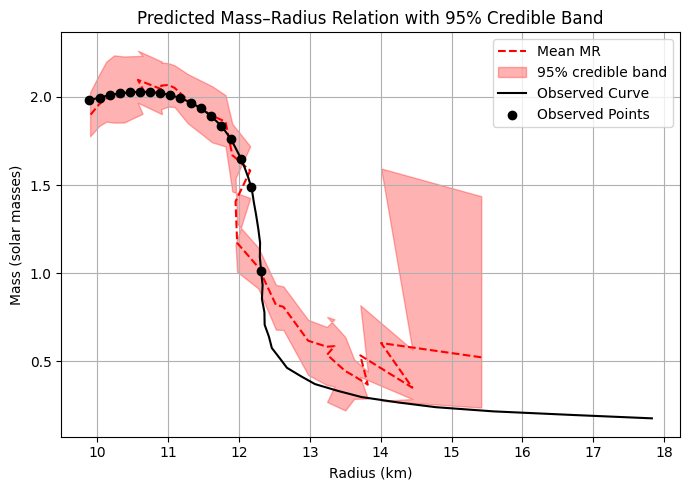

In [ ]:
mean_M = M_pred_samples.mean(axis=0)

lower_M = np.percentile(M_pred_samples, 2.5, axis=0)
upper_M = np.percentile(M_pred_samples, 97.5, axis=0)

plt.figure(figsize=(7, 5))
plt.plot(mean_R, mean_M, "--", label="Mean MR", color="red", zorder=2)

# 95% credible band
plt.fill_between(
    mean_R,
    lower_M,
    upper_M,
    alpha=0.3,
    label="95% credible band",
    zorder=1,
    color="red"
)

# Observed continuous curve (example: ID=19248, model='RMFNL')
mask = (observed_mr["ID"] == 19248) & (observed_mr["model"] == "RMFNL")
plt.plot(
    observed_mr.loc[mask, "R"].values,
    observed_mr.loc[mask, "M"].values,
    color="black",
    label="Observed Curve",
    zorder=3,
)

# Observed discrete points
plt.scatter(radius_obs, mass_obs, color="black", marker="o",
            label="Observed Points", zorder=4)

# Labels, legend, etc.
plt.xlabel("Radius (km)")
plt.ylabel("Mass (solar masses)")
plt.title("Predicted Mass–Radius Relation with 95% Credible Band")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()